Download Dataset

In [ ]:
import os
os.environ['KAGGLE_USERNAME']   = 'faiqfadlurrahman'
os.environ['KAGGLE_KEY']        = 'e2c32ad38e4c088f672dd912a447ad32'

!kaggle datasets download -d linkgish/indonesian-fact-and-hoax-political-news

import zipfile

zip_ref = zipfile.ZipFile('/content/indonesian-fact-and-hoax-political-news.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

 99% 100M/101M [00:01<00:00, 71.3MB/s] 
100% 101M/101M [00:01<00:00, 67.3MB/s]


## Read and Pre Processing

In [ ]:
## FUNGSI PREPROCESSING
import pandas as pd
import string
import re
from keras.src.utils import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def preprocessing(df):
    # Menjadikan huruf kecil
    df['Title'] = df['Title'].str.lower()

    # Fungsi untuk mengganti spasi dengan tanda baca
    def space_to_punct(text):
        for punct in string.punctuation:
            text = text.replace(punct, f' {punct} ')

        text = re.sub(' +', ' ', text)
        return text

    # Mengaplikasikan fungsi space_to_punct ke kolom 'Title'
    df['Title'] = df['Title'].apply(space_to_punct)

    # Fungsi untuk melakukan preprocessing
    def preprocess_text(text):
        # Menghapus angka
        text = re.sub(r"\d+", "", text)
        # Menghapus tanda baca
        text = text.translate(str.maketrans("", "", string.punctuation))
        # Menghapus spasi berlebih
        text = text.strip()
        text = re.sub('\s+', ' ', text)
        return text

    # Mengaplikasikan preprocessing ke kolom 'Title'
    df['Title'] = df['Title'].apply(preprocess_text)

    # Fungsi untuk menghapus karakter dan emotikon
    def remove_special_characters(text):
        # Mengganti karakter yang diinginkan dengan string kosong
        text_cleaned = re.sub("[”“‘’\"″]", "", text)

        # Mengganti emotikon dengan string kosong
        emoticon_pattern = "["
        emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
        emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
        emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
        emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
        emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
        emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
        emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
        emoticon_pattern += u"\U000024C2-\U0001F251"
        emoticon_pattern += "]+"
        text_cleaned = re.sub(emoticon_pattern, "", text_cleaned, flags=re.UNICODE)

        return text_cleaned

    # Menggunakan fungsi untuk menghapus karakter dan emotikon dari kolom "title"
    df['Title'] = df['Title'].apply(remove_special_characters)

    # Download stopwords jika belum diunduh
    nltk.download('stopwords')

    # Mengambil stopwords dalam bahasa Indonesia
    list_stopwords = set(stopwords.words('indonesian'))

    # Menghapus stopwords dari setiap kalimat di kolom 'Title'
    df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in list_stopwords]))

    return df

## FUNGSI WORDCLOUD
def generate_and_display_wordcloud(data_df, label_value):
    # Filter data berdasarkan label
    filtered_data = data_df[data_df['hoax'] == label_value]

    # Gabungkan semua teks dari kolom 'title' yang memiliki label tertentu menjadi satu teks panjang
    text = " ".join(filtered_data['Title'])

    # Membuat Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

    # Menampilkan Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## FUNGSI TRAIN TEST SPLIT
def split_data(features, labels, test_size=0.2, random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return x_train,x_test, y_train, y_test

## FUNGSI PLOT AKURASI DAN LOSS
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

## FUNGSI EVALUATE DAN CONFUSSION MATRIX
def evaluate_and_visualize(model, x_train, y_train, X_test, y_test):
    # Print accuracy on training and testing data
    train_accuracy = model.evaluate(x_train, y_train)[1] * 100
    test_accuracy = model.evaluate(X_test, y_test)[1] * 100
    print("Accuracy of the model on Training Data is - ", train_accuracy)
    print("Accuracy of the model on Testing Data is - ", test_accuracy)

    # Predictions on test data
    predictions = model.predict(X_test)
    predictions_integer = (predictions > 0.5).astype(int)

    print("Sample Predictions:", predictions_integer[:5])

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, predictions_integer))

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions_integer)
    cm = pd.DataFrame(cm, index=['Real', 'Hoax'], columns=['Real', 'Hoax'])

    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Real', 'Hoax'],
                yticklabels=['Real', 'Hoax'])
    plt.title('Confusion Matrix')
    plt.show()

## FUNGSI PREDICT TEST KALIMAT
PADDING = 'post'
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions

      Unnamed: 0                                              Title  \
0              0  Anies di Milad BKMT: Pengajian Menghasilkan Ib...   
1              1  Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...   
2              2  PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...   
3              3    Gede Pasek Doakan AHY Jadi Capres atau Cawapres   
4              4  PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...   
...          ...                                                ...   
9625        9994  Aroma Politik di Balik Penetapan 1 Juni Hari L...   
9626        9995  Jokowi Wanti-wanti Ekspansi Ideologi Transnasi...   
9627        9996  PBNU: Tak ada Pertentangan antara Islam dan Pa...   
9628        9997  Jokowi Bicara Ideologi Transnasional di Revolu...   
9629        9998  Hari Lahir Pancasila, Jokowi Waspadai Rivalita...   

                          Timestamp  \
0     Selasa, 21 Feb 2023 21:22 WIB   
1     Selasa, 21 Feb 2023 20:46 WIB   
2     Selasa, 21 Feb 2023 20:3

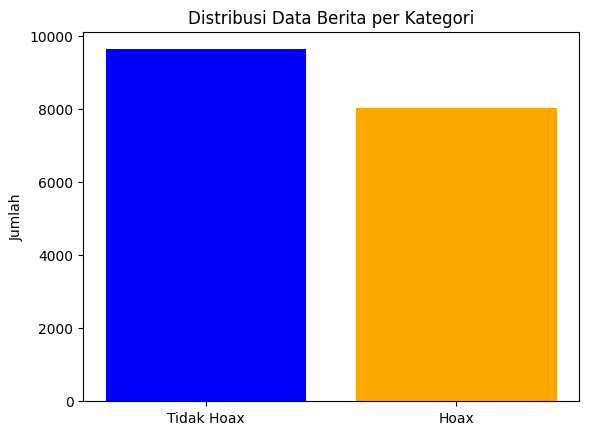

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['Alhamdulillah', ',', 'hari', 'ini', 'cuacanya', 'cerah', '.', 'Tapi', ',', 'sore', 'hari', 'hujan']
Title    object
hoax      int64
dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                   Title  hoax
0      anies milad bkmt pengajian menghasilkan berpen...     0
1          edy pilgub sumut maju abal abal terpaksa maju     0
2      pkb daftarkan menaker ida fauziyah caleg dpr p...     0
3                  gede pasek doakan ahy capres cawapres     0
4      pkn siapkan jabatan khusus anas urbaningrum be...     0
...                                                  ...   ...
17651                        kayu manis vs kencing manis     1
17652  admin mca tertangkap polisi menikmati makan ba...     1
17653  penyerangan muazin masjid agung pameungpeuk garut     1
17654     kemkominfo help desk registrasi kartu prabayar     1
17655                       jokowi maaf pki keluarga pki     1

[17656 rows x 2 columns]


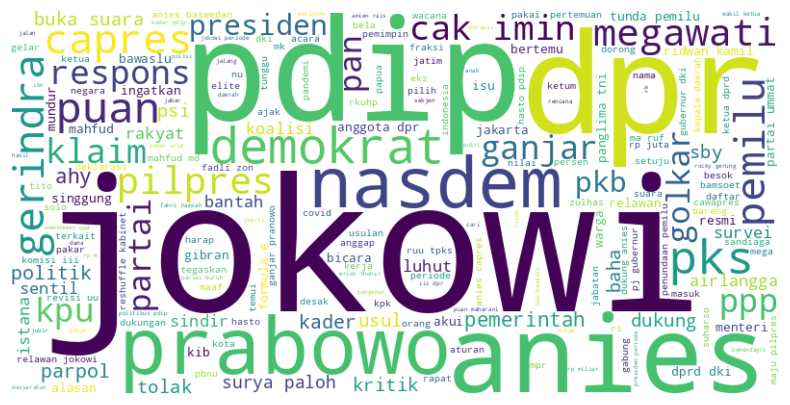

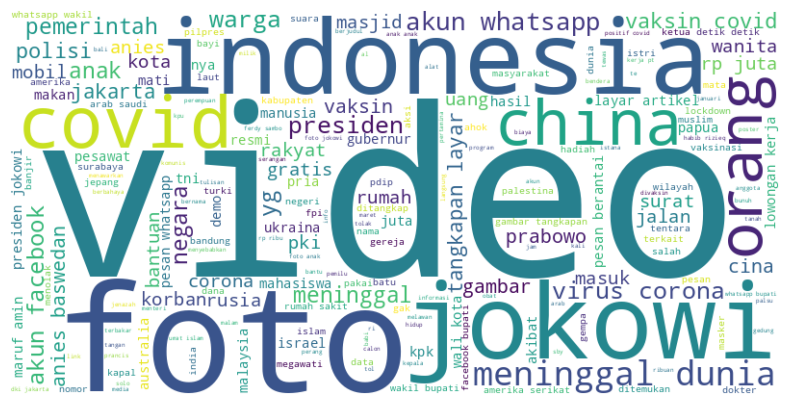

In [ ]:
"""# Reading Data"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from keras.src.optimizers import Adam
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
# from proses import preprocessing, generate_and_display_wordcloud, split_data, plot_graphs, \
#     evaluate_and_visualize, predict_sentences

fact_df = pd.read_excel('/content/Cleaned/dataset_cnn_10k_cleaned.xlsx')
#fact_df['Hoax'] = 0

hoax_df = pd.read_excel('/content/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx')
#hoax_df['Hoax'] = 1


print(fact_df)

print(fact_df.dtypes)

print(hoax_df.dtypes)

"""## Cek Kolom"""

print(fact_df.columns)

fact_df = fact_df.drop(columns=['Unnamed: 0','Timestamp','FullText','Tags','Author','Url','text_new'])

print(fact_df)

print(hoax_df)

print(hoax_df.columns)

hoax_df = hoax_df.drop(columns=['Unnamed: 0','Timestamp','FullText','Tags','Author','Url','politik','Narasi','Clean Narasi'])

print(hoax_df)

print(hoax_df[hoax_df['Title'].isna()])

#Menghilangkan kata [SALAH] di judul Hoax
hoax_df = hoax_df[hoax_df['Title'].str.contains(r'\[SALAH\]', regex=True)]
print(hoax_df.head())

print("\nSetelah Remove [SALAH]")
# Menghapus kata '[SALAH]' dari kolom 'Title'
hoax_df['Title'] = hoax_df['Title'].str.replace(r'\[SALAH\]', '',regex=True)
print(hoax_df.head())


#Menghapus Tanda Kutip dari Judul Berita Hoax
# Menghilangkan tanda kutip di awal dan akhir teks dalam kolom 'Title'
print('\nSetelah Remove "" Tanda Kutip')
#hoax_df['Title'] = hoax_df['Title'].str.strip('“”')
hoax_df['Title'] = hoax_df['Title'].str.strip().str.strip('“”')
#hoax_df['Title'] = hoax_df['Title'].str.strip('"')
hoax_df['Title'] = hoax_df['Title'].str.strip().str.strip('""')

print(hoax_df)

print(hoax_df[hoax_df['Title'].str.contains(r'\[SALAH\]', regex=True)])

"""## Kombinasi Fact and Hoax"""

news_df = pd.concat([fact_df.iloc[:], hoax_df.iloc[:]], axis=0, ignore_index=True)
#news_df = pd.concat([fact_df.iloc[:], fact_df1.iloc[:],hoax_df.iloc[:],], axis=0, ignore_index=True)

print(news_df)

"""## Representasi Jumlah Data"""

# Menghitung jumlah angka 0 dan 1 dalam kolom "hoax"
hoax_count = news_df['hoax'].value_counts()

# Warna untuk masing-masing nilai
colors = ['blue', 'orange']

# Membuat diagram batang dengan warna yang berbeda untuk masing-masing nilai
plt.bar(hoax_count.index, hoax_count.values, color=colors)
#plt.xlabel('Hoax')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak Hoax', 'Hoax'])
plt.title('Distribusi Data Berita per Kategori')
plt.show()

# download corpus punkt
nltk.download('punkt')

text = "Alhamdulillah, hari ini cuacanya cerah. Tapi, sore hari hujan"
print(word_tokenize(text))

print(news_df.dtypes)

news_df.count()

"""# Preprocessing

## FUNGSI PREPROCESSING FIX
"""

# Contoh penggunaan:
news_df = preprocessing(news_df)

print(news_df)

"""## WordCloud Real , RUN SETELAH REMOVE STOPWORD"""

# Contoh penggunaan fungsi untuk non-hoax
generate_and_display_wordcloud(news_df, label_value=0)

# Contoh penggunaan fungsi untuk hoax
generate_and_display_wordcloud(news_df, label_value=1)


In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Mengecek keberadaan karakter "”", "″", "‘", "’", dan emotikon di dalam kolom "title"
for character in ["”", "″", "‘", "’"]:
    contains_character = news_df['Title'].str.contains(character)
    print(f"Contains '{character}':\n{news_df[contains_character]}")

# Mengecek keberadaan emotikon di dalam kolom "title"
emoticon_pattern = "["
emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
emoticon_pattern += u"\U000024C2-\U0001F251"
emoticon_pattern += "]+"

contains_emoticon = news_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{news_df[contains_emoticon]}")


Contains '”':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '″':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '‘':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '’':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


In [ ]:
import pandas as pd
import re

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Fungsi untuk menghapus karakter dan emotikon
def remove_special_characters(text):
    # Mengganti karakter yang diinginkan dengan string kosong
    text_cleaned = re.sub("[”“‘’\"″]", "", text)

    # Mengganti emotikon dengan string kosong
    emoticon_pattern = "["
    emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
    emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
    emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
    emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
    emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
    emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
    emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
    emoticon_pattern += u"\U000024C2-\U0001F251"
    emoticon_pattern += "]+"
    text_cleaned = re.sub(emoticon_pattern, "", text_cleaned, flags=re.UNICODE)

    return text_cleaned

# Menggunakan fungsi untuk menghapus karakter dan emotikon dari kolom "title"
news_df['Title'] = news_df['Title'].apply(remove_special_characters)

# Menampilkan DataFrame yang sudah diupdate
print(news_df[['Title']])

                                                   Title
0      anies milad bkmt pengajian menghasilkan berpen...
1          edy pilgub sumut maju abal abal terpaksa maju
2      pkb daftarkan menaker ida fauziyah caleg dpr p...
3                  gede pasek doakan ahy capres cawapres
4      pkn siapkan jabatan khusus anas urbaningrum be...
...                                                  ...
17651                        kayu manis vs kencing manis
17652  admin mca tertangkap polisi menikmati makan ba...
17653  penyerangan muazin masjid agung pameungpeuk garut
17654     kemkominfo help desk registrasi kartu prabayar
17655                       jokowi maaf pki keluarga pki

[17656 rows x 1 columns]


In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame news_df
# news_df = ...

# Mengecek keberadaan karakter "”", "″", "‘", "’", dan emotikon di dalam kolom "title"
for character in ["”", "″", "‘", "’"]:
    contains_character = news_df['Title'].str.contains(character)
    print(f"Contains '{character}':\n{news_df[contains_character]}")

# Mengecek keberadaan emotikon di dalam kolom "title"
emoticon_pattern = "["
emoticon_pattern += u"\U0001F600-\U0001F64F"  # Emotikon umum
emoticon_pattern += u"\U0001F300-\U0001F5FF"  # Simbol & peta
emoticon_pattern += u"\U0001F680-\U0001F6FF"  # Transportasi & simbol umum
emoticon_pattern += u"\U0001F700-\U0001F77F"  # Alat & simbol teknis
emoticon_pattern += u"\U0001F780-\U0001F7FF"  # Alat & seni
emoticon_pattern += u"\U0001F800-\U0001F8FF"  # Variasi warna
emoticon_pattern += u"\U0001F900-\U0001F9FF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA00-\U0001FA6F"  # Emoji & simbol tambahan
emoticon_pattern += u"\U0001FA70-\U0001FAFF"  # Emoji & simbol tambahan
emoticon_pattern += u"\U00002702-\U000027B0"  # Emoji & simbol tambahan
emoticon_pattern += u"\U000024C2-\U0001F251"
emoticon_pattern += "]+"

contains_emoticon = news_df['Title'].str.contains(emoticon_pattern, flags=re.UNICODE)
print(f"Contains emoticon:\n{news_df[contains_emoticon]}")

Contains '”':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '″':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '‘':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains '’':
Empty DataFrame
Columns: [Title, hoax]
Index: []
Contains emoticon:
Empty DataFrame
Columns: [Title, hoax]
Index: []


## Split Train Test

In [ ]:
# grader-required-cell

#NUM_WORDS = 12000
EMBEDDING_DIM = 50
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

# Splitting the data into 80% training and 20% testing
#x_train, x_test, y_train, y_test = train_test_split(news_df['Title'], news_df['hoax'], test_size=0.2, random_state=42)
# Gantilah news_df['Title'] dan news_df['hoax'] sesuai dengan nama kolom yang sesuai dalam DataFrame Anda.
x_train, x_test, y_train, y_test = split_data(news_df['Title'], news_df['hoax'], test_size=0.2, random_state=42)

print("Jumlah data dalam set pelatihan:", x_train.shape[0])
print("Jumlah data dalam set pengujian:", x_test.shape[0])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(x_train)

print(x_test)

print(y_train)

print(y_test)

Jumlah data dalam set pelatihan: 14124
Jumlah data dalam set pengujian: 3532
(14124,)
(3532,)
(14124,)
(3532,)
2194     fx rudy bertolak jakarta penuhi panggilan pdip...
5098                 jokowi undang kpu istana bahas pemilu
5198            sekjen pan dicecar kuasa hukum ade armando
9982        jus daun pepaya obat demam berdarah dengue dbd
8166             golkar berpeluang koalisi gerindra nasdem
                               ...                        
11284    ton minyak goreng tumpah laut wilayah karianga...
11964    jepang ivermectin menghentikan vaksin memberan...
5390      rk usulkan nama penjabat daerah jabar kemendagri
860      demokrat pecat wakil ketua dprd solok terjerat...
15795    video karyawan menyortir memasukkan masker ply...
Name: Title, Length: 14124, dtype: object
9918     foto selebaran waspada penculikan anak anak be...
8630                 dpr aturan disiplin kerja pns terarah
6486     projo patuh konstitusi sikapi isu penundaan pe...
1087                p

In [ ]:
import pandas as pd

# Konversi array NumPy menjadi DataFrame
x_train_df = pd.DataFrame(x_train)

# Simpan DataFrame ke dalam file CSV
x_train_df.to_csv('x_train.csv', index=False)

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
x_test.to_csv('df_test.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_result_updated.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_result_updated.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

### Membuat Dataframe Result Untuk Training Data

In [ ]:
## Ini harusnya sebelum Diubah ke angka
# Membuat DataFrame
df_train = pd.DataFrame({
    'Text': x_train,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada X_test
    'True_Label': y_train,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada y_test
})

In [ ]:
# Reset index
df_train = df_train.reset_index(drop=True)

In [ ]:
df_train

,Text,True_Label
0,fx rudy bertolak jakarta penuhi panggilan pdip...,0
1,jokowi undang kpu istana bahas pemilu,0
2,sekjen pan dicecar kuasa hukum ade armando,0
3,jus daun pepaya obat demam berdarah dengue dbd,1
4,golkar berpeluang koalisi gerindra nasdem,0
...,...,...
14119,ton minyak goreng tumpah laut wilayah karianga...,1
14120,jepang ivermectin menghentikan vaksin memberan...,1
14121,rk usulkan nama penjabat daerah jabar kemendagri,0
14122,demokrat pecat wakil ketua dprd solok terjerat...,0


In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_train.to_csv('df_data_train.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

### Membuat Dataframe Result Untuk Testing Data

In [ ]:
## Ini harusnya sebelum Diubah ke angka
# Membuat DataFrame
df_result = pd.DataFrame({
    'Text': x_test,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada X_test
    'True_Label': y_test,  # Gantilah dengan nama kolom sesuai dengan data yang ada pada y_test
})

In [ ]:
# Reset index
df_result = df_result.reset_index(drop=True)

In [ ]:
df_result

,Text,True_Label
0,foto selebaran waspada penculikan anak anak be...,1
1,dpr aturan disiplin kerja pns terarah,0
2,projo patuh konstitusi sikapi isu penundaan pe...,0
3,peserta pemilu partai ummat nomor urut,0
4,foto rumah sakit tega meloloskan bapa membawa ...,1
...,...,...
3527,surat izin pekerja asing izin pati malaysia,1
3528,pdip megawati sby,0
3529,jokowi ma ruf amin saksi nikah anak mensesneg ...,0
3530,pabrik mobil nissan umumkan tutup usahanya maret,1


In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_data_test.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai

## Tokenizing dan Padding

In [ ]:
"""## 4.Tokenizing"""

#Tokenizing Text -> Repsesenting each word by a number
#tokenizer = Tokenizer(num_words = NUM_WORDS,oov_token = OOV_TOKEN)
max_features = 15000
maxlen = 30

tokenizer = Tokenizer(num_words=max_features,oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)

#padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
x_train = pad_sequences(tokenized_train,padding=PADDING, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test,padding=PADDING ,maxlen=maxlen)

print(x_train)

print(x_train[24])

word_index = tokenizer.word_index

#print(word_index)

print(len(word_index))

[[  526   544  3331 ...     0     0     0]
 [    2   545    22 ...     0     0     0]
 [  161    39  2504 ...     0     0     0]
 ...
 [  332   565    68 ...     0     0     0]
 [   16   648   106 ...     0     0     0]
 [    5   796 14191 ...     0     0     0]]
[   5  887  111 4042   35 7354  733 1458 2508 7355 7356  189 7357    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
14193


## Model Word2Vec 50 Dimension

In [ ]:
!kaggle datasets download -d greegtitan/indonesia-word2vec-embbeding

zip_ref = zipfile.ZipFile('/content/indonesia-word2vec-embbeding.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

 99% 226M/228M [00:04<00:00, 95.9MB/s]
100% 228M/228M [00:04<00:00, 51.9MB/s]


In [ ]:
import numpy as np
from nltk.tokenize import word_tokenize

embeddings_dictionary = {}
with open('/content/word2vec.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

vocab_length = 15000 # modify
embedding_dim = 50

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenizer.word_index.items(): # change depending on your data
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
vocab_length = len(embeddings_dictionary)
print("Vocabulary Length:", vocab_length)

Vocabulary Length: 375580


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.32997906,  1.92328143,  0.78425694, ..., -4.19898653,
         1.8912133 , -0.24774863],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_vector

array([-0.14025575,  0.00234831, -0.00151553,  0.13935304,  0.3192729 ,
       -0.2073879 ,  0.28116342,  0.12684914,  0.2368512 ,  0.08041051,
       -0.03167948, -0.16237964, -0.11926271, -0.18172836, -0.53611183,
        0.2535305 , -0.13210927,  0.21496764,  0.02837791,  0.19059072,
        0.011199  , -0.02655403,  0.19582097, -0.44442743, -0.13598806,
       -0.1701494 , -0.2540683 , -0.0333418 , -0.11343756, -0.38534027,
       -0.09297059, -0.05752426,  0.1286215 ,  0.11217514, -0.16652714,
        0.09684978,  0.02307596, -0.08015823,  0.28594944,  0.15776923,
        0.0480112 ,  0.07297048,  0.01791649,  0.02498409, -0.08008983,
        0.2383406 , -0.05966923, -0.02982575, -0.12202854,  0.01663417],
      dtype=float32)

In [ ]:
# Get the dimensions from the loaded embeddings
embedding_vector.shape[0]

50

In [ ]:
embedding_matrix.shape[0]

15000

### Cek vektor kata dan yang berdekatan

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Mencari vektor kata "saya"
vector_saya = embeddings_dictionary.get("saya")

# Mencari kata-kata berdekatan berdasarkan cosine similarity
similar_words = {}
for word, vector in embeddings_dictionary.items():
    similarity = cosine_similarity([vector_saya], [vector])[0][0]
    similar_words[word] = similarity

# Mengurutkan kata-kata berdasarkan similarity (dalam urutan menurun)
similar_words = sorted(similar_words.items(), key=lambda x: x[1], reverse=True)

# Menampilkan hasil
print("Kata-kata berdekatan dengan 'saya':")
for word, similarity in similar_words[:10]:  # Ambil 10 kata teratas
    print(f"{word}: {similarity}")

Kata-kata berdekatan dengan 'saya':
saya: 0.9999999403953552
anda: 0.8985090851783752
kita: 0.8144623637199402
kami: 0.7886889576911926
pertanyaannya: 0.7717043161392212
jawabannya: 0.7637986540794373
aku: 0.7532833218574524
ybs: 0.7514180541038513
sy: 0.7429542541503906
utcsaya: 0.7377897500991821


## Build Model with Word2Vec

### Model 1

Model 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 1/

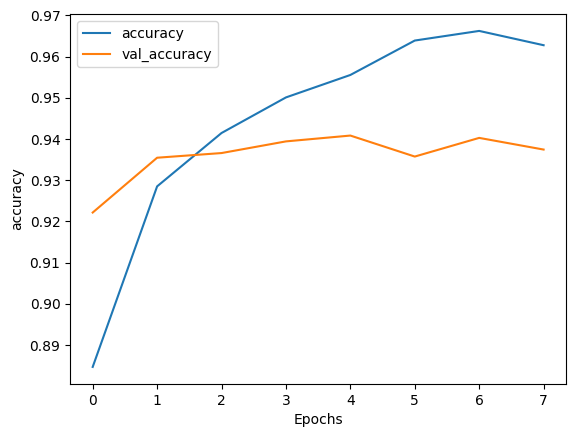

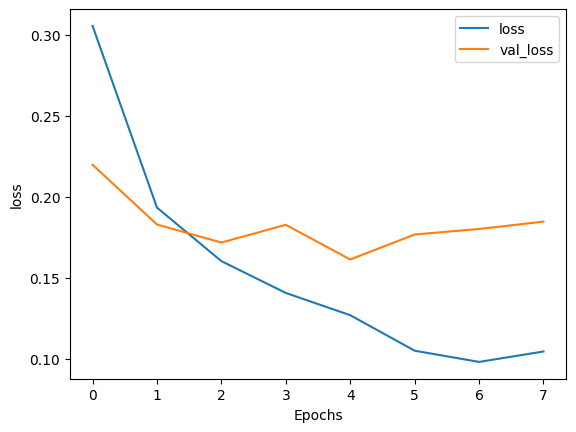

111/111 [==============================] - 1s 8ms/step - loss: 0.1848 - accuracy: 0.9374
Accuracy of the model on Training Data is -  97.39450812339783
Accuracy of the model on Testing Data is -  93.74291896820068
111/111 [==============================] - 1s 8ms/step
Sample Predictions: [[1]
 [0]
 [0]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1926
           1       0.93      0.94      0.93      1606

    accuracy                           0.94      3532
   macro avg       0.94      0.94      0.94      3532
weighted avg       0.94      0.94      0.94      3532

      Real  Hoax
Real  1806   120
Hoax   101  1505


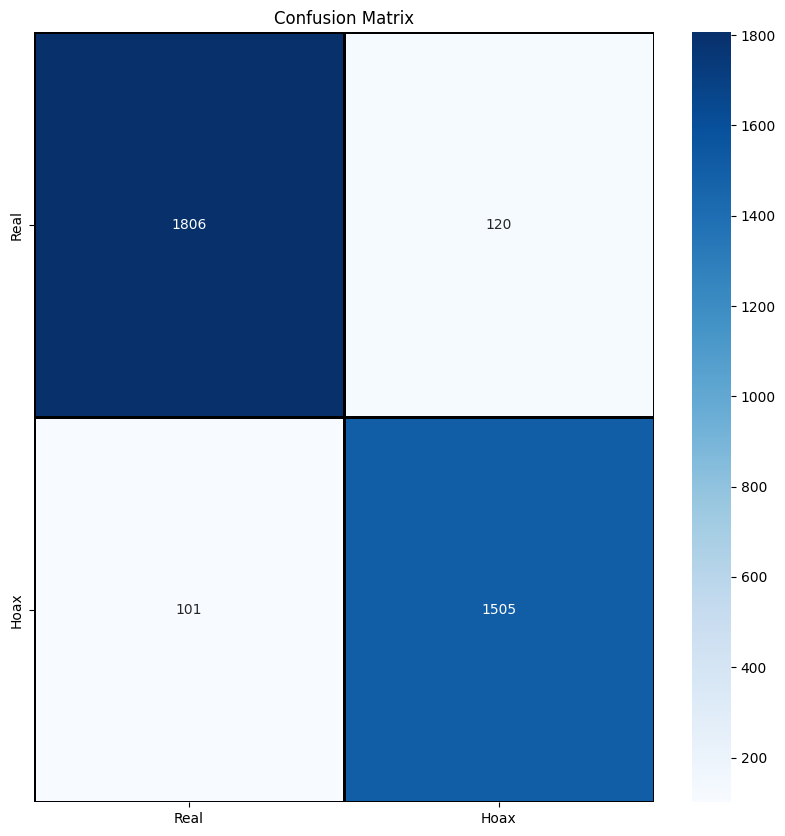

In [ ]:
max_features = 15000
batch_size = 64
epochs = 8
# 10 terlalu banyak , overfitting
embed_size = 50

# Function to build the model
"""## MODEL

### Model 1

*   **Epoch** : 5
*   **Dimension Embedding** : 100
*   **Hidden Layer**  : 64
*   **Batch Size**    : 64
*   **Optimizer**     : Adam
*   **Learning Rate**  : 0.01
"""

def build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate):
    max_features =  15000# Isi dengan nilai sesuai kebutuhan
    maxlen =  30 # Isi dengan nilai sesuai kebutuhan
    # x_train, y_train, X_test, y_test harus sudah didefinisikan sebelumnya

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
        input_dim=max_features,
        output_dim=embedding_dim,  # Adjusted to match the pre-trained embedding dimension
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False  # Optional: Set to True if you want to fine-tune the embeddings
    ),
        #tf.keras.layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen),
        tf.keras.layers.LSTM(hidden_layer_size),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    model.summary()

    history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs)

    return history,model

# Contoh pemanggilan fungsi:
#epochs = 5
#embed_size = 50
hidden_layer_size = 64
#batch_size = 64
learning_rate = 0.01

print("Model 1")
# Contoh pemanggilan untuk dua model dengan nama yang berbeda
history,model = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Usage
evaluate_and_visualize(model, x_train, y_train, X_test, y_test)

In [ ]:
# Example usage
input_sentences = ["anies meninggal dunia", "jokowi minta maaf kepada pki","gede pasek doakan ahy menjadi capres","CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH",
                   "Beban Utang Prabowo Subianto 7,6 Triliun"]

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 24ms/step
[[0.9912075 ]
 [0.31192926]
 [0.09669045]
 [0.97677046]
 [0.34456345]]
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Real

Sentence: gede pasek doakan ahy menjadi capres
Prediction: Real

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Hoax

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Real



In [ ]:
# Example usage
input_sentences = ["foto “selebaran waspada penculikan anak anak berumur polda metro jaya",
                   "dpr aturan disiplin kerja pns terarah",
                   "projo patuh konstitusi sikapi isu penundaan pemilu",
                   "peserta pemilu partai ummat nomor urut",
                   "foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor"]

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 23ms/step
[[0.9987468 ]
 [0.00316603]
 [0.00373999]
 [0.00700112]
 [0.9987894 ]]
Sentence: foto “selebaran waspada penculikan anak anak berumur polda metro jaya
Prediction: Hoax

Sentence: dpr aturan disiplin kerja pns terarah
Prediction: Real

Sentence: projo patuh konstitusi sikapi isu penundaan pemilu
Prediction: Real

Sentence: peserta pemilu partai ummat nomor urut
Prediction: Real

Sentence: foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor
Prediction: Hoax



In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Menyimpan model di luar fungsi
model.save("model_lstm1.h5")
print("Model telah disimpan sebagai 'model_lstm1.h5'.")

Model telah disimpan sebagai 'model_lstm1.h5'.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model_load = load_model('model_lstm1.h5')
model.summary()

# Example usage
input_sentences = ["foto “selebaran waspada penculikan anak anak berumur polda metro jaya",
                   "dpr aturan disiplin kerja pns terarah",
                   "projo patuh konstitusi sikapi isu penundaan pemilu",
                   "peserta pemilu partai ummat nomor urut",
                   "foto “rumah sakit tega meloloskan bapa membawa pulang mayat anaknya sepeda motor"]

predictions = predict_sentences(input_sentences, model_load, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model = load_model('model_lstm1.h5')
model.summary()

# FUNGSI PREDICT TEST KALIMAT
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions,predictions

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

In [ ]:
model.save('my_lstm1.keras')

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
# Load pre-trained model and tokenizer

model = load_model('my_lstm1.keras')
#loaded_model = tf.keras.models.load_model('my_model.keras')
model.summary()

# FUNGSI PREDICT TEST KALIMAT
def predict_sentences(sentences, model, tokenizer, max_len):
    # Tokenize and pad the input sentences
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=PADDING, maxlen=max_len)

    # Make predictions using the model
    predictions = model.predict(padded)

    print(predictions)

    # Convert predictions to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions,predictions

predictions = predict_sentences(input_sentences, model, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            750000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
1/1 [===========

### Model 2

Model 2
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

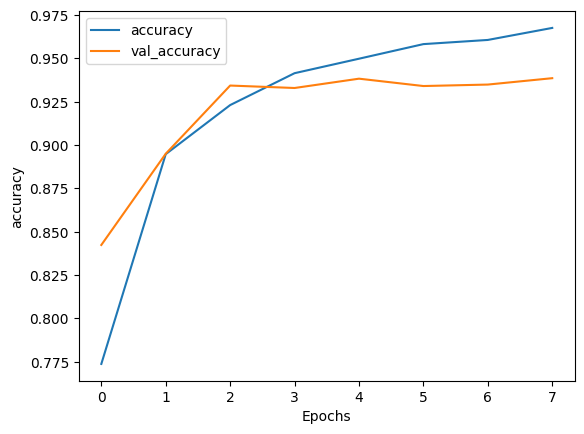

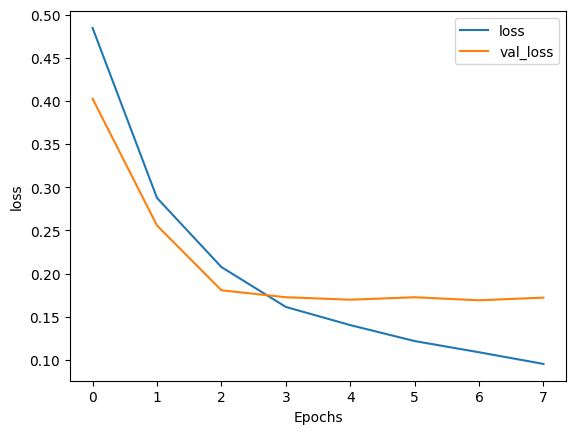

111/111 [==============================] - 1s 6ms/step - loss: 0.1721 - accuracy: 0.9386
Accuracy of the model on Training Data is -  97.86887764930725
Accuracy of the model on Testing Data is -  93.8561737537384
111/111 [==============================] - 1s 5ms/step
Sample Predictions: [[1]
 [0]
 [0]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1926
           1       0.93      0.94      0.93      1606

    accuracy                           0.94      3532
   macro avg       0.94      0.94      0.94      3532
weighted avg       0.94      0.94      0.94      3532

      Real  Hoax
Real  1808   118
Hoax    99  1507


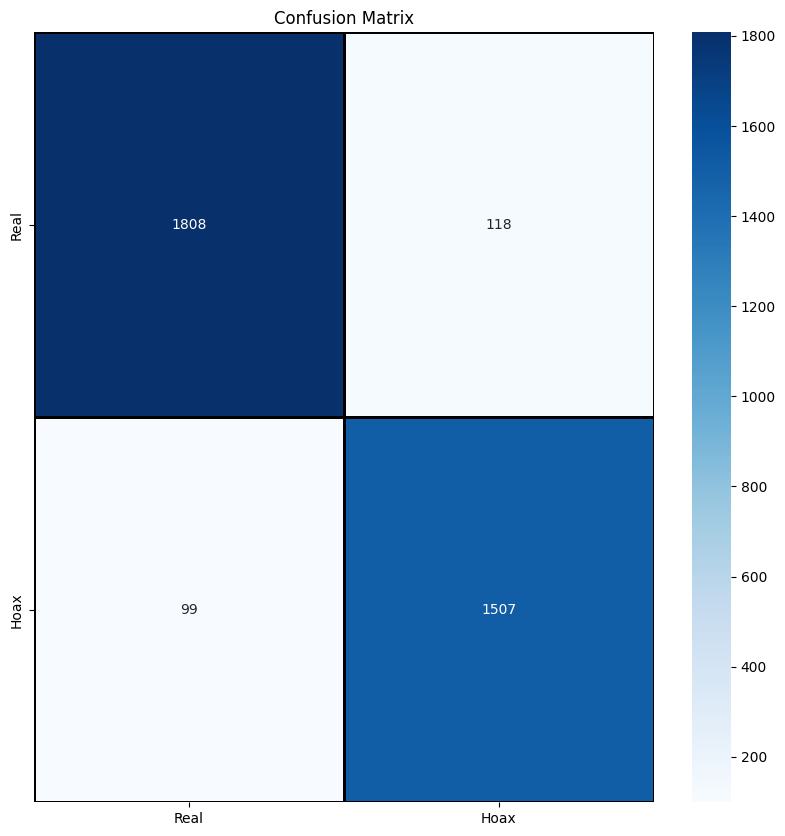

1/1 [==============================] - 0s 20ms/step
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Hoax

Sentence: gede pasek doakan ahy menjadi capres
Prediction: Real

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Hoax

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Hoax



In [ ]:
"""### Model 2

*   **Epoch** : 5
*   **Dimension Embedding** : 100
*   **Hidden Layer**  : 64
*   **Batch Size**    : 64
*   **Optimizer**     : Adam
*   **Learning Rate**  : 0.001

"""

#epochs = 5
#embed_size = 50
hidden_layer_size = 64
batch_size = 64
learning_rate = 1e-2

print("Model 2")
history2,model2 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# Usage
evaluate_and_visualize(model2, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model2, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

### Model 3

In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 64
optimizer = 'Adam'
learning_rate = 1e-3

print("Model 3")
history3,model3 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

# Usage
evaluate_and_visualize(model3, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model3, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

Model 3


NameError: name 'build_and_train_model' is not defined

### Model 4

Model 4
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

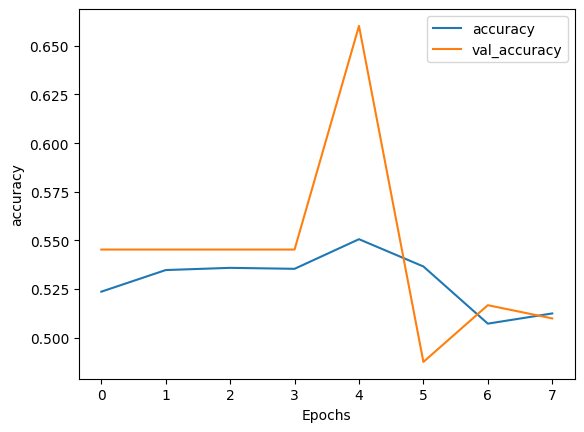

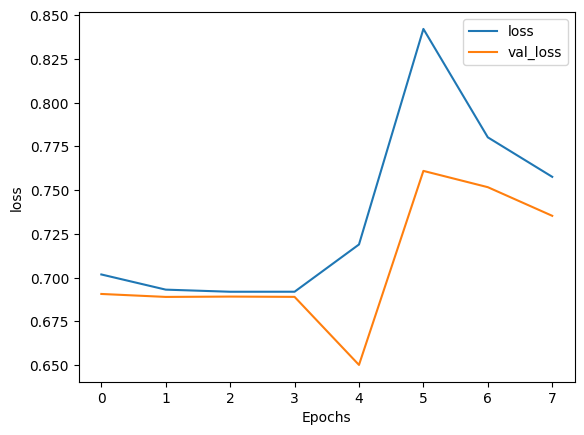

111/111 [==============================] - 1s 6ms/step - loss: 0.7354 - accuracy: 0.5099
Accuracy of the model on Training Data is -  50.934576988220215
Accuracy of the model on Testing Data is -  50.990939140319824
111/111 [==============================] - 1s 6ms/step
Sample Predictions: [[0]
 [1]
 [0]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.49      0.52      1926
           1       0.47      0.53      0.50      1606

    accuracy                           0.51      3532
   macro avg       0.51      0.51      0.51      3532
weighted avg       0.52      0.51      0.51      3532

      Real  Hoax
Real   942   984
Hoax   747   859


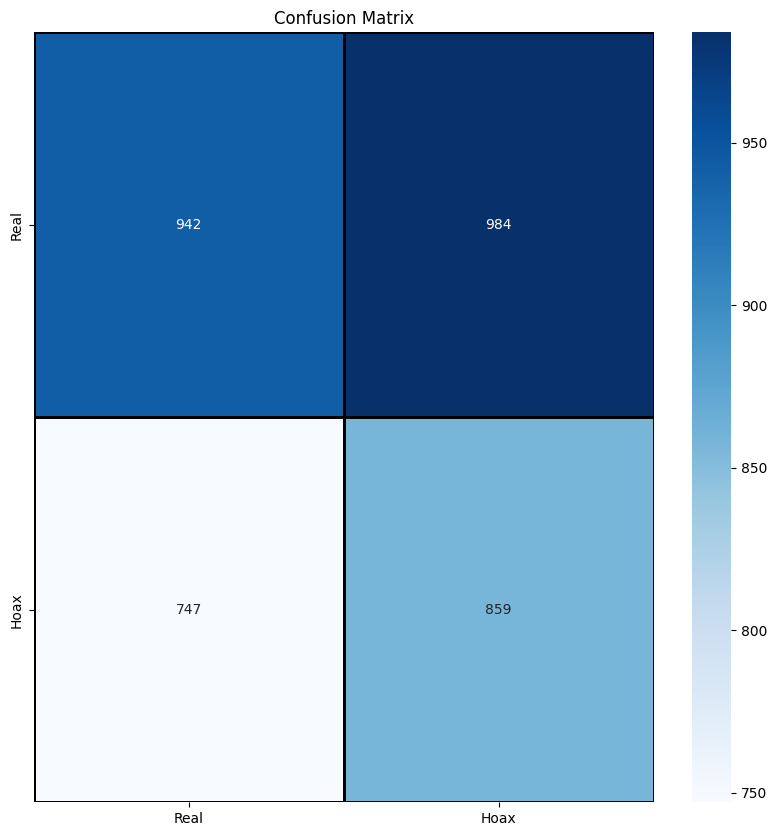

In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-1

print("Model 4")
history4,model4 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history4, "accuracy")
plot_graphs(history4, "loss")

# Usage
evaluate_and_visualize(model4, x_train, y_train, X_test, y_test)


In [ ]:
# Example usage

predictions = predict_sentences(input_sentences, model4, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

1/1 [==============================] - 0s 26ms/step
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Hoax

Sentence: gede pasek doakan ahy menjadi capres
Prediction: Hoax

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Real

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Hoax



### Model 5

Model 5
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

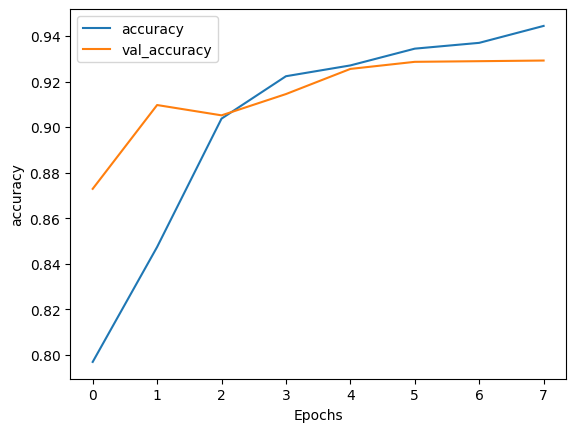

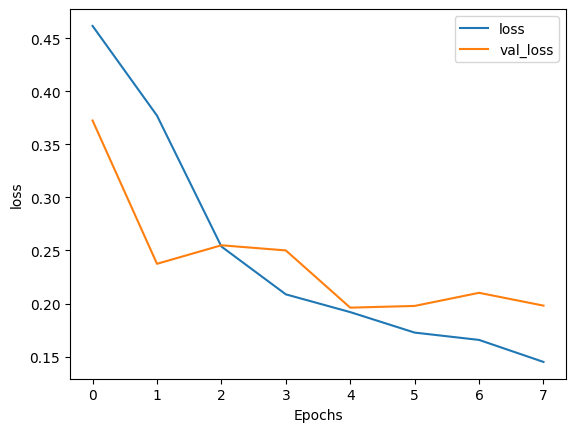

111/111 [==============================] - 1s 6ms/step - loss: 0.1980 - accuracy: 0.9292
Accuracy of the model on Training Data is -  95.74483036994934
Accuracy of the model on Testing Data is -  92.9218590259552
111/111 [==============================] - 1s 6ms/step
Sample Predictions: [[1]
 [0]
 [0]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1926
           1       0.94      0.91      0.92      1606

    accuracy                           0.93      3532
   macro avg       0.93      0.93      0.93      3532
weighted avg       0.93      0.93      0.93      3532

      Real  Hoax
Real  1827    99
Hoax   151  1455


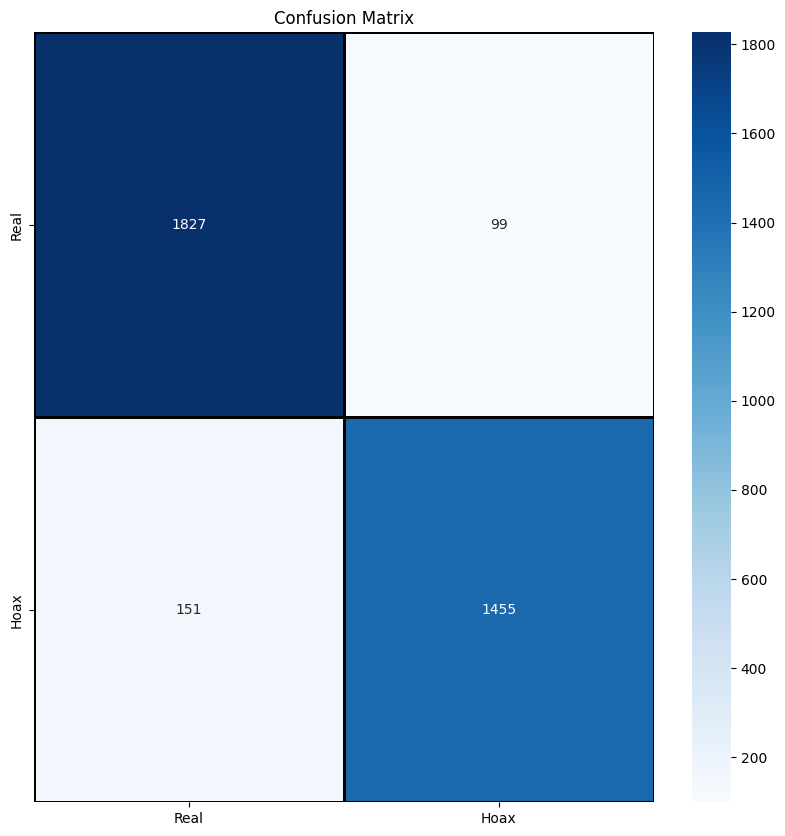

1/1 [==============================] - 0s 20ms/step
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Real

Sentence: gede pasek doakan ahy menjadi capres
Prediction: Real

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Hoax

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Real



In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-2

print("Model 5")
history5,model5 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history5, "accuracy")
plot_graphs(history5, "loss")

# Usage
evaluate_and_visualize(model5, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model5, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")

### Model 6

Model 6
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 50)            750000    
                                                                 
 lstm_7 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779505 (2.97 MB)
Trainable params: 29505 (115.25 KB)
Non-trainable params: 750000 (2.86 MB)
_________________________________________________________________
Epoch 

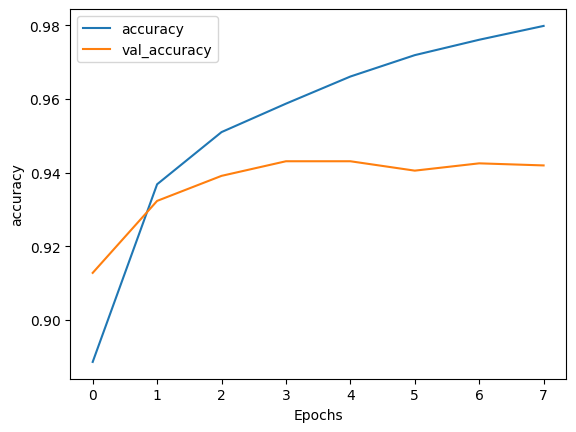

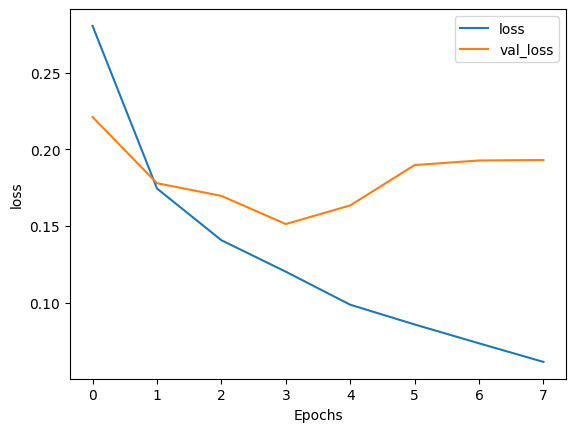

111/111 [==============================] - 1s 6ms/step - loss: 0.1930 - accuracy: 0.9420
Accuracy of the model on Training Data is -  98.25828671455383
Accuracy of the model on Testing Data is -  94.19592022895813
111/111 [==============================] - 1s 5ms/step
Sample Predictions: [[1]
 [0]
 [0]
 [0]
 [1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1926
           1       0.95      0.92      0.94      1606

    accuracy                           0.94      3532
   macro avg       0.94      0.94      0.94      3532
weighted avg       0.94      0.94      0.94      3532

      Real  Hoax
Real  1849    77
Hoax   128  1478


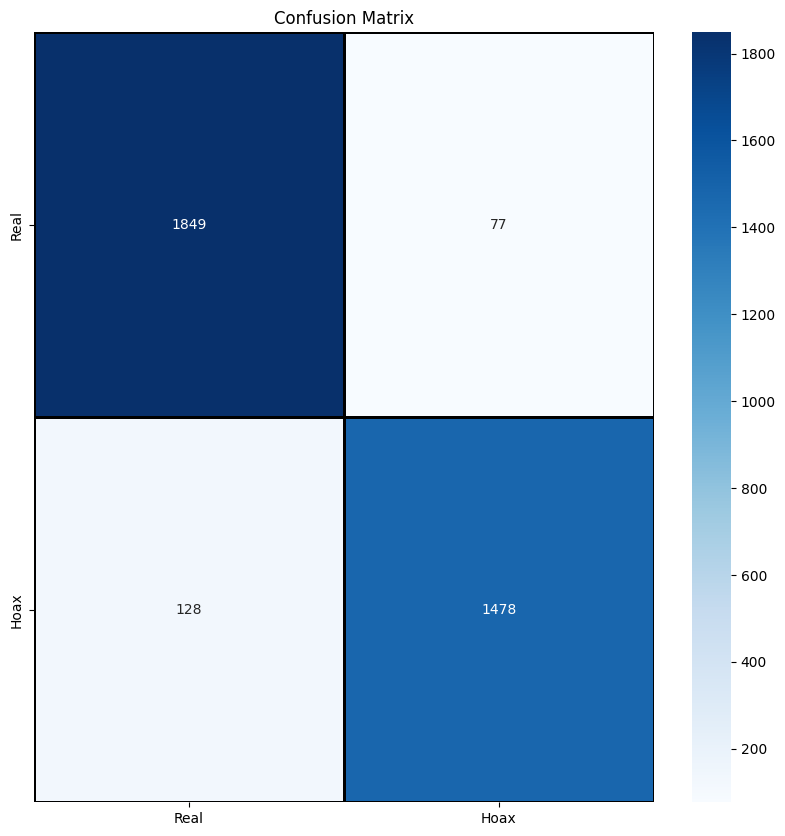

1/1 [==============================] - 0s 25ms/step
Sentence: anies meninggal dunia
Prediction: Hoax

Sentence: jokowi minta maaf kepada pki
Prediction: Hoax

Sentence: gede pasek doakan ahy menjadi capres
Prediction: Real

Sentence: CAK NUN SEBUT JOKOWI SEPERTI FIR’AUN KARENA DISURUH
Prediction: Real

Sentence: Beban Utang Prabowo Subianto 7,6 Triliun
Prediction: Real



In [ ]:
#epochs = 5
#embed_size = 100
hidden_layer_size = 64
batch_size = 32
optimizer = 'Adam'
learning_rate = 1e-3

print("Model 6")
history6,model6 = build_and_train_model(epochs, embed_size, hidden_layer_size, batch_size, learning_rate)

plot_graphs(history6, "accuracy")
plot_graphs(history6, "loss")

# Usage
evaluate_and_visualize(model6, x_train, y_train, X_test, y_test)

# Example usage

predictions = predict_sentences(input_sentences, model6, tokenizer, maxlen)

for sentence, prediction in zip(input_sentences, predictions):
    print(f"Sentence: {sentence}\nPrediction: {'Hoax' if prediction[0] == 1 else 'Real'}\n")


## Test Kode Real Label == Predict Label

In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame df_result
# df_result = ...

# Misalnya, sentences adalah kolom 'text' pada DataFrame
sentences = df_result['Text']

max_len =30
# Memanggil fungsi predict_sentences untuk memperoleh prediksi biner
binary_predictions = predict_sentences(sentences, model, tokenizer, max_len)

# Menambahkan kolom 'predicted_label' ke DataFrame
df_result['predicted_label'] = binary_predictions

# Menambahkan kolom 'is_correct' yang berisi label true jika 'predicted_label' sama dengan 'true_label'
df_result['is_correct'] = df_result['predicted_label'] == df_result['True_Label']

111/111 [==============================] - 1s 13ms/step


In [ ]:
def evaluate_confusion_matrix_class(true_label, predicted_label):
    if true_label == 0 and predicted_label == 0:
        return "True Positive"
    elif true_label == 1 and predicted_label == 0:
        return "False Positive"
    elif true_label == 1 and predicted_label == 1:
        return "True Negative"
    elif true_label == 0 and predicted_label == 1:
        return "False Negative"

# Misalnya, sentences adalah kolom 'text' pada DataFrame
sentences = df_result['Text']

max_len = 30
# Memanggil fungsi predict_sentences untuk memperoleh prediksi biner
binary_predictions = predict_sentences(sentences, model, tokenizer, max_len)

# Menambahkan kolom 'predicted_label' ke DataFrame
df_result['predicted_label'] = binary_predictions

# Menambahkan kolom fungsi dengan "True Positive" jika predicted_label = true_label == real
# "False Positive" jika true_label = hoax tapi predicted_label=real
# "True Negative" jika predicted_label = true_label == hoax
# "False Negative" jika true_label = real tetapi predicted_label=hoax
df_result['confusion_matrix_class'] = df_result.apply(lambda row: evaluate_confusion_matrix_class(row['True_Label'], row['predicted_label']), axis=1)

111/111 [==============================] - 1s 7ms/step
[[0.9987458 ]
 [0.00316603]
 [0.00373999]
 ...
 [0.05113568]
 [0.9987766 ]
 [0.99816483]]


In [ ]:
df_result

,Text,True_Label,predicted_label,confusion_matrix_class
0,foto selebaran waspada penculikan anak anak be...,1,1,True Negative
1,dpr aturan disiplin kerja pns terarah,0,0,True Positive
2,projo patuh konstitusi sikapi isu penundaan pe...,0,0,True Positive
3,peserta pemilu partai ummat nomor urut,0,0,True Positive
4,foto rumah sakit tega meloloskan bapa membawa ...,1,1,True Negative
...,...,...,...,...
3527,surat izin pekerja asing izin pati malaysia,1,1,True Negative
3528,pdip megawati sby,0,0,True Positive
3529,jokowi ma ruf amin saksi nikah anak mensesneg ...,0,0,True Positive
3530,pabrik mobil nissan umumkan tutup usahanya maret,1,1,True Negative


In [ ]:
# Menghitung jumlah label true dan false dari kolom 'is_correct'
label_counts = df_result['confusion_matrix_class'].value_counts()

# Menampilkan hasil
print(label_counts)

True Positive     1806
True Negative     1505
False Negative     120
False Positive     101
Name: confusion_matrix_class, dtype: int64


In [ ]:
import pandas as pd

# Misalkan Anda sudah mempunyai DataFrame df_result
# df_result = ...

# Menghitung jumlah label true dan false dari kolom 'is_correct'
label_counts = df_result['is_correct'].value_counts()

# Menampilkan hasil
print("Jumlah label True:", label_counts[True])
print("Jumlah label False:", label_counts[False])

Jumlah label True: 3288
Jumlah label False: 244


In [ ]:
# Misalkan Anda sudah mempunyai DataFrame df_result
# df_result = ...

# Menampilkan data di mana label asli adalah 0 tetapi diprediksi 1
false_positive = df_result[(df_result['True_Label'] == 0) & (df_result['predicted_label'] == 1)]

# Menampilkan data di mana label asli adalah 1 tetapi diprediksi 0
false_negative = df_result[(df_result['True_Label'] == 1) & (df_result['predicted_label'] == 0)]

# Menampilkan hasil
print("Data False Positive:")
false_positive

print("\nData False Negative:")
false_negative

Data False Positive:


,Text,True_Label,predicted_label,is_correct
7635,kekerasan seksual dunia digital masuk ruu tpks,0,1,False
3447,relawan pesan jokowi bersyukur beli bbm antre ...,0,1,False
3780,luhut prabowo indonesia kerap dituduh komunis,0,1,False
9267,jokowi didesak turun tangan ngabalin setop pol...,0,1,False
7971,sby didiagnosis kanker prostat jalani perawata...,0,1,False
...,...,...,...,...
7640,komika mongol stres resmi gabung psi,0,1,False
2959,pemuda madiun jual channel telegram bjorka,0,1,False
925,makassar godok raperda anti lgbt,0,1,False
5587,demo mahasiswa sambut kunjungan jokowi sumenep,0,1,False


In [ ]:
print("\nData False Negative:")
false_negative


Data False Negative:


,Text,True_Label,predicted_label,is_correct
14256,hadapi ancaman stm pakar intelejen densus ting...,1,0,False
15946,arief budiman kutuk batu kpu curang,1,0,False
15100,pks menolak bersandiwara,1,0,False
16834,teriak jokowi periode lelaki dihajar warga bon...,1,0,False
14145,infografis bawaslu kepri kampanye,1,0,False
...,...,...,...,...
10730,hillary clinton mengaku terinspirasi sri mulya...,1,0,False
9746,megawati resmi ganjar maju capres,1,0,False
16188,penjual bakso mantan intel menyamar,1,0,False
16638,tv negeri memberitakan prabowo the next presiden,1,0,False


In [ ]:
# Misalkan df_result adalah DataFrame Anda
# df_result = ...

# Reset index
df_result = df_result.reset_index(drop=True)

# Menampilkan DataFrame setelah direset index
print(df_result)

                                                   Text  True_Label  \
0     foto selebaran waspada penculikan anak anak be...           1   
1                 dpr aturan disiplin kerja pns terarah           0   
2     projo patuh konstitusi sikapi isu penundaan pe...           0   
3                peserta pemilu partai ummat nomor urut           0   
4     foto rumah sakit tega meloloskan bapa membawa ...           1   
...                                                 ...         ...   
3527        surat izin pekerja asing izin pati malaysia           1   
3528                                  pdip megawati sby           0   
3529  jokowi ma ruf amin saksi nikah anak mensesneg ...           0   
3530   pabrik mobil nissan umumkan tutup usahanya maret           1   
3531        cctv titik daerah jakarta sengaja dimatikan           1   

      predicted_label confusion_matrix_class  
0                   1          True Negative  
1                   0          True Positive  
2     

In [ ]:
# Menyimpan DataFrame yang sudah diperbarui
df_result.to_csv('df_result_updated.csv', index=False)  # Gantilah dengan nama file dan path yang sesuai